<a href="https://colab.research.google.com/github/andrew-mecchi/andrew-mecchi.github.io/blob/main/K_Means_Clustering_D212_Data_Mining_II_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Upload CSV file and create backup
data = pd.read_csv(r'/content/drive/MyDrive/data_files/churn_clean_d212_t1.csv')
data_backup = data.copy(deep = True)

# Rename Item columns to represent their corresponding survey category
data.rename(columns = {'Item1':'Timely_response',
                       'Item2': 'Timely_fixes',
                       'Item3':'Timely_replacements',
                       'Item4':'Reliability',
                       'Item5':'Options',
                       'Item6':'Respectful_response',
                       'Item7':'Courteous_staff',
                       'Item8':'Active_listeners'}, inplace = True)


# View first 3 rows of dataframe
data.head(3)


,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Timely_response,Timely_fixes,Timely_replacements,Reliability,Options,Respectful_response,Courteous_staff,Active_listeners
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3


In [4]:
# Explore data
# Confirm no duplicate entries for data by checking for unique customer ids

data['Customer_id'].duplicated().value_counts()


False    10000
Name: Customer_id, dtype: int64

In [5]:
# Search for null values

data.isnull().sum()


CaseOrder               0
Customer_id             0
Interaction             0
UID                     0
City                    0
State                   0
County                  0
Zip                     0
Lat                     0
Lng                     0
Population              0
Area                    0
TimeZone                0
Job                     0
Children                0
Age                     0
Income                  0
Marital                 0
Gender                  0
Churn                   0
Outage_sec_perweek      0
Email                   0
Contacts                0
Yearly_equip_failure    0
Techie                  0
Contract                0
Port_modem              0
Tablet                  0
InternetService         0
Phone                   0
Multiple                0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
PaperlessBilling        0
PaymentMetho

In [ ]:
# Explore data types, identify target variables
# Search df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CaseOrder             10000 non-null  int64  
 1   Customer_id           10000 non-null  object 
 2   Interaction           10000 non-null  object 
 3   UID                   10000 non-null  object 
 4   City                  10000 non-null  object 
 5   State                 10000 non-null  object 
 6   County                10000 non-null  object 
 7   Zip                   10000 non-null  int64  
 8   Lat                   10000 non-null  float64
 9   Lng                   10000 non-null  float64
 10  Population            10000 non-null  int64  
 11  Area                  10000 non-null  object 
 12  TimeZone              10000 non-null  object 
 13  Job                   10000 non-null  object 
 14  Children              10000 non-null  int64  
 15  Age                 

In [ ]:
# What features are most common for patients who churn vs. remain loyal?
# CONTINUOUS/DISCRETE numerical -- age, children, income, monthly charges, bandwidth/gb/year, tenure

t1 = data[['Age', 'Children', 'Income', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Tenure']]

# View new df

t1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                10000 non-null  int64  
 1   Children           10000 non-null  int64  
 2   Income             10000 non-null  float64
 3   MonthlyCharge      10000 non-null  float64
 4   Bandwidth_GB_Year  10000 non-null  float64
 5   Tenure             10000 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 468.9 KB


In [ ]:
# View summary statistics - data to be scaled using standard scaler
t1.describe()


,Age,Children,Income,MonthlyCharge,Bandwidth_GB_Year,Tenure
count,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.078400,2.0877,39806.926771,172.624816,3392.341550,34.526188
std,20.698882,2.1472,28199.916702,42.943094,2185.294852,26.443063
min,18.000000,0.0000,348.670000,79.978860,155.506715,1.000259
25%,35.000000,0.0000,19224.717500,139.979239,1236.470827,7.917694
50%,53.000000,1.0000,33170.605000,167.484700,3279.536903,35.430507
75%,71.000000,3.0000,53246.170000,200.734725,5586.141370,61.479795
max,89.000000,10.0000,258900.700000,290.160419,7158.981530,71.999280


In [ ]:
# Create copy of t1 for k-means analysis
df_km = t1.copy(deep = True)

# View first three rows to confirm
df_km.head(3)

# Export dataframe used for analysis to csv file
df_km.to_csv(r'C:\\Users\\andrew\\Desktop\\WGU_MSDA\\D212_Data_Mining_II\\PA\\Task_1\\df_km_clean_data_set.csv')


In [ ]:
# Instantiate standard scaler
scaler = StandardScaler()

# Scale data for optimal cluster analysis
scaled_opt = scaler.fit_transform(df_km)

# View array of scaled data --- first three values
scaled_opt[:3]

array([[ 0.72092524, -0.97233791, -0.39877774, -0.00394256, -1.13848703,
        -1.04874621],
       [-1.25995716, -0.50659192, -0.64195445,  1.6303259 , -1.18587584,
        -1.26200116],
       [-0.14873045,  0.89064606, -1.07088496, -0.29522482, -0.61213775,
        -0.7099398 ]])

In [ ]:
# Find optimal number of clusters
# Use Elbow method identifying upto 9 clusters
# Optimal number determined by "elbow" in plot

# Define Cluster range and empty list of inertia values
cluster = range(1, 10)
inertia_value = []

# Create loop to iterate number of clusters 1-9
for k in cluster:
  km = KMeans(n_clusters = k, init = 'k-means++', n_init = 1, random_state = 61)
  km.fit(scaled_opt)
  inertia_value.append(km.inertia_)


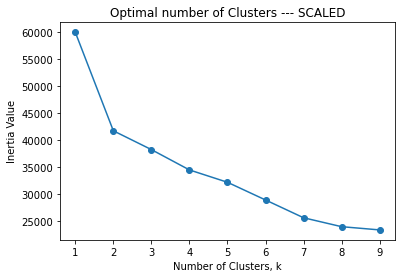

In [ ]:
# Elbow Plot of optimal clusters
plt.plot(cluster, inertia_value, '-o')
plt.title("Optimal number of Clusters --- SCALED")
plt.xlabel("Number of Clusters, k")
plt.ylabel("Inertia Value")
plt.xticks(cluster)
plt.show()

In [ ]:
# Elbow plot unclear if 2, 3, or 4 clusters are optimal
# Assess values of "k" using Silhouette Method
# SOURCE --- (Banerji, 2023)

#create loop for silhouette scores
clusters = range(2, 10)
silhouette_scores = []

for k in clusters:
 kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 1, random_state = 61)
 kmeans.fit_transform(scaled_opt)
 labels = kmeans.labels_
 silhouette_scores.append(silhouette_score(scaled_opt, labels))


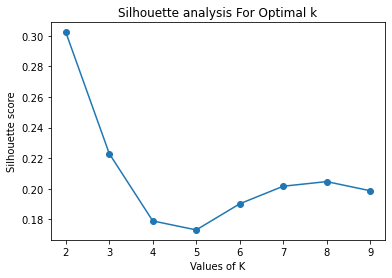

In [ ]:
# plot silhouette scores
plt.plot(clusters, silhouette_scores, '-o')
plt.xlabel("Values of K")
plt.ylabel("Silhouette score")
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [ ]:
# Silhouette Score Values
# SOURCE --- (Scikit-learn, n.d)
clusters = range(2, 10)

for k in clusters:
   kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 1, random_state = 61)
   labels = kmeans.fit_predict(scaled_opt)
   sil_score = silhouette_score(scaled_opt, labels)
   print("For n_clusters =", k, "The average silhouette_score is :", round(sil_score, 3))

For n_clusters = 2 The average silhouette_score is : 0.302
For n_clusters = 3 The average silhouette_score is : 0.223
For n_clusters = 4 The average silhouette_score is : 0.179
For n_clusters = 5 The average silhouette_score is : 0.173
For n_clusters = 6 The average silhouette_score is : 0.19
For n_clusters = 7 The average silhouette_score is : 0.202
For n_clusters = 8 The average silhouette_score is : 0.205
For n_clusters = 9 The average silhouette_score is : 0.199


In [ ]:
# Optimal number of clusters confirmed to be 2, with the highest silhouette score
# 2 clusters has silhouette score of 0.302
# Define clusters as 2

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Instantiate scaler and define k-means model with number of clusters = 2
scaler = StandardScaler()
km_model = KMeans(n_clusters = 2, init = 'k-means++', n_init = 1, random_state = 61)

# Create pipeline
pipeline = make_pipeline(scaler, km_model)


In [ ]:
# Fit the pipeline to df_km
pipeline.fit(df_km)

# Identify Labels
labels = pipeline.predict(df_km)

In [ ]:
# Confrim array of label clusters
labels

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# Create new dataframe from original df to add cluster labels

results = df_km.copy(deep = True)

# Add cluster labels back to df with readmissions included for comparison of features
# Add labels to km results df
results['clusters'] = labels


In [ ]:
# View results dataframe
results.head(3)

,Age,Children,Income,MonthlyCharge,Bandwidth_GB_Year,Tenure,clusters
0,68,0,28561.99,172.455519,904.536110,6.795513,0
1,27,1,21704.77,242.632554,800.982766,1.156681,0
2,50,4,9609.57,159.947583,2054.706961,15.754144,0


In [ ]:
# View value counts of cluster analysis
results['clusters'].value_counts()

0    5002
1    4998
Name: clusters, dtype: int64

In [ ]:
# Analyze k-means cluster model
scaler = StandardScaler()
km_model = KMeans(n_clusters = 2, init = 'k-means++', n_init = 1, random_state = 61)
X = scaler.fit_transform(df_km)
labels = km_model.fit_predict(X)


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X, labels, metric = 'euclidean')
print("For the 2-cluster k-means model, the Silhouette Score is: ", round(silhouette_avg, 3))

For the 2-cluster k-means model, the Silhouette Score is:  0.302


In [ ]:
results.describe()

,Age,Children,Income,MonthlyCharge,Bandwidth_GB_Year,Tenure,clusters
count,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,53.078400,2.0877,39806.926771,172.624816,3392.341550,34.526188,0.499800
std,20.698882,2.1472,28199.916702,42.943094,2185.294852,26.443063,0.500025
min,18.000000,0.0000,348.670000,79.978860,155.506715,1.000259,0.000000
25%,35.000000,0.0000,19224.717500,139.979239,1236.470827,7.917694,0.000000
50%,53.000000,1.0000,33170.605000,167.484700,3279.536903,35.430507,0.000000
75%,71.000000,3.0000,53246.170000,200.734725,5586.141370,61.479795,1.000000
max,89.000000,10.0000,258900.700000,290.160419,7158.981530,71.999280,1.000000


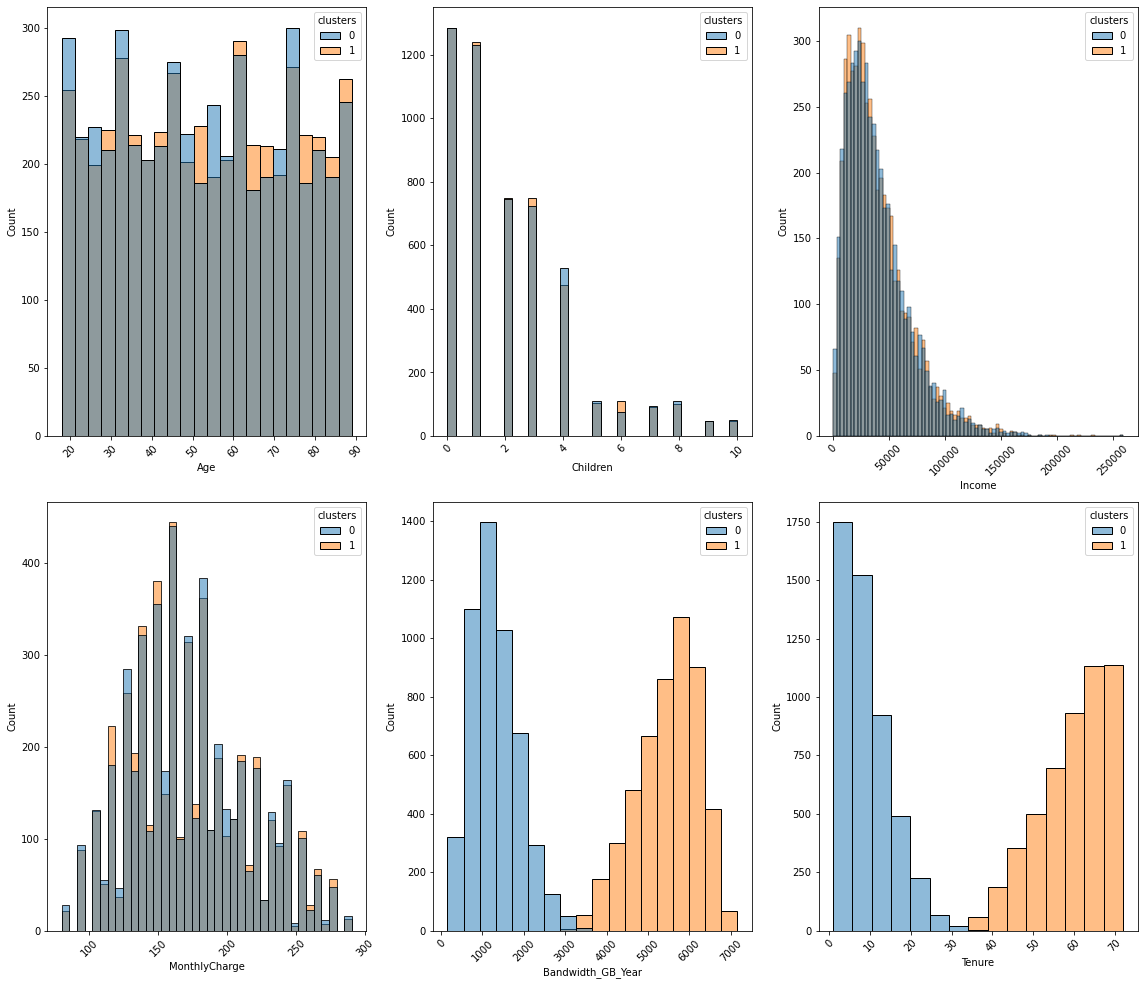

In [ ]:
# Histogram plot loop of variables selected for k-means analysis
results_hist = results[['Age', 'Children', 'Income', 'MonthlyCharge', 'Bandwidth_GB_Year', 'Tenure']]
fig_hist = plt.figure(figsize=(16, 20))
clusters = results['clusters']

for i, col in enumerate(results_hist):

    ax = fig_hist.add_subplot(3, 3, i+1)

    sns.histplot(x = results[col], ax = ax, hue = clusters )
    plt.xticks(rotation = 45)
    fig_hist.tight_layout();

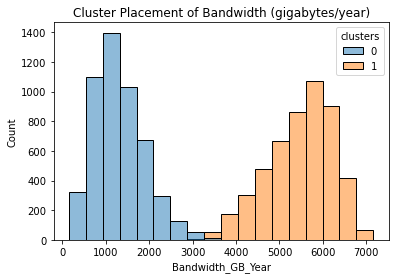

In [ ]:
# Closer look at Bandwidth and cluster placement
sns.histplot(x = 'Bandwidth_GB_Year', hue = 'clusters', data = results)
plt.title("Cluster Placement of Bandwidth (gigabytes/year)");

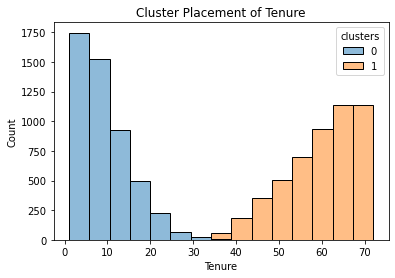

In [ ]:
# Closer look at Tenure and cluster placement
sns.histplot(x = 'Tenure', hue = 'clusters', data = results)
plt.title("Cluster Placement of Tenure");

In [ ]:
# Cluster analysis
cluster_0 = results[results['clusters'] == 0]
cluster_1 = results[results['clusters'] == 1]


In [ ]:
# Cluster 0 summary statistics
cluster_0.describe()


,Age,Children,Income,MonthlyCharge,Bandwidth_GB_Year,Tenure,clusters
count,5002.000000,5002.000000,5002.000000,5002.000000,5002.000000,5002.000000,5002.0
mean,52.680928,2.094962,39742.893623,172.717941,1312.667000,9.139358,0.0
std,20.697432,2.154495,28030.075671,42.879005,573.211784,6.049647,0.0
min,18.000000,0.000000,348.670000,79.978860,155.506715,1.000259,0.0
25%,35.000000,0.000000,19287.632500,139.981600,886.340948,4.333129,0.0
50%,52.000000,1.000000,33385.635000,169.937800,1236.830103,7.918159,0.0
75%,71.000000,3.000000,53519.085000,200.160512,1671.435057,12.574988,0.0
max,89.000000,10.000000,258900.700000,290.160419,3575.871459,37.119120,0.0


In [ ]:
# Cluster 1 summary statistics
cluster_1.describe()

,Age,Children,Income,MonthlyCharge,Bandwidth_GB_Year,Tenure,clusters
count,4998.00000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.0
mean,53.47619,2.080432,39871.011166,172.531617,5473.680505,59.933335,1.0
std,20.69476,2.140066,28371.535684,43.011227,751.503936,8.470829,0.0
min,18.00000,0.000000,643.200000,79.978860,3170.023123,34.807934,1.0
25%,35.00000,0.000000,19166.002500,139.967800,4967.387548,54.380205,1.0
50%,53.00000,1.000000,33010.660000,167.456400,5586.594665,61.480545,1.0
75%,71.00000,3.000000,52997.942500,202.443300,6036.335497,66.858477,1.0
max,89.00000,10.000000,256998.400000,290.160400,7158.981530,71.999280,1.0


In [ ]:
# Closer look at bandwidth and tenure between clusters 0 and 1
print("Cluster 0")
print(cluster_0[['Bandwidth_GB_Year', 'Tenure']].describe())
print('\n')
print("Cluster 1")
print(cluster_1[['Bandwidth_GB_Year', 'Tenure']].describe())

Cluster 0
       Bandwidth_GB_Year       Tenure
count        5002.000000  5002.000000
mean         1312.667000     9.139358
std           573.211784     6.049647
min           155.506715     1.000259
25%           886.340948     4.333129
50%          1236.830103     7.918159
75%          1671.435057    12.574988
max          3575.871459    37.119120


Cluster 1
       Bandwidth_GB_Year       Tenure
count        4998.000000  4998.000000
mean         5473.680505    59.933335
std           751.503936     8.470829
min          3170.023123    34.807934
25%          4967.387548    54.380205
50%          5586.594665    61.480545
75%          6036.335497    66.858477
max          7158.981530    71.999280


In [ ]:
# Isolate mean, min, max of bandwidth and tenure from clusters 0 and 1
# Cluster 0 bandwidth
c0_band_mean = cluster_0['Bandwidth_GB_Year'].mean()
c0_band_min = cluster_0['Bandwidth_GB_Year'].min()
c0_band_max = cluster_0['Bandwidth_GB_Year'].max()

# Cluster 1 bandwidth
c1_band_mean = cluster_1['Bandwidth_GB_Year'].mean()
c1_band_min = cluster_1['Bandwidth_GB_Year'].min()
c1_band_max = cluster_1['Bandwidth_GB_Year'].max()

# Cluster 0 tenure
c0_tenure_mean = cluster_0['Tenure'].mean()
c0_tenure_min = cluster_0['Tenure'].min()
c0_tenure_max = cluster_0['Tenure'].max()

# Cluster 1 tenure
c1_tenure_mean = cluster_1['Tenure'].mean()
c1_tenure_min = cluster_1['Tenure'].min()
c1_tenure_max = cluster_1['Tenure'].max()

In [ ]:
# Prepare statistics for feature summary
dictionary = {'cluster_0' : [c0_band_mean, c0_band_min, c0_band_max, c0_tenure_mean, c0_tenure_min, c0_tenure_max], 'cluster_1' : [c1_band_mean, c1_band_min, c1_band_max, c1_tenure_mean, c1_tenure_min, c1_tenure_max]}

# Create dataframe for feature summary
feature_summary = pd.DataFrame(data = dictionary, index=['Bandwidth - Mean(avg.)', 'Bandwidth - Min', 'Bandwidth - Maximum', 'Tenure - Mean(avg.)', 'Tenure - Min', 'Tenure - Maximum'])

In [ ]:
# View feature summary
feature_summary

,cluster_0,cluster_1
Bandwidth - Mean(avg.),1312.667000,5473.680505
Bandwidth - Min,155.506715,3170.023123
Bandwidth - Maximum,3575.871459,7158.981530
Tenure - Mean(avg.),9.139358,59.933335
Tenure - Min,1.000259,34.807934
Tenure - Maximum,37.119120,71.999280
